###### An amortization schedule is a table that shows the periodic principal and interest payments needed to pay of a debt.

* The most common case is the payoff schedule for a mortgage.
* It is possible that you can pay almost as much in interest as the original loan was worth. Because of the financial importance of this purchase, it is important to understand all the financial ramifications of a mortgage.
* This model assumes that an individual pays exactly the prescribed amount each period.

In [1]:
import pandas as pd
import numpy as np
from datetime import date

* The basic parts of the solution for a 30 year \$200K mortgage structured with a monthly payment and an annual interest rate of 4%.
* With an extra $50/month to pay down the principal more quickly.

In [2]:
Interest_Rate = 0.04
Years = 30
Payments_Year = 12
Principal = 200000
Addl_Princ = 50
start_date = (date(2016,1,1))

###### C:\acor\Scripts>pip install numpy-financial

In [3]:
import numpy_financial as npf
pmt = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
# Compute the payment against loan principal plus interest: this means that every month we need to pay $954.83 
pmt

-954.8305909309076

In [4]:
# Period to calculate
per = 1
# Calculate the interest
ipmt = npf.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)
# Calculate the principal
ppmt = npf.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)
# The first payment of $954.83 is composed of $666.67 in interest and only $288.16 in principal.
print(ipmt, ppmt)

-666.6666666666667 -288.1639242642409


In [5]:
per = 240 # the breakdown for period 240
# Calculate the interest
ipmt = npf.ipmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)
# Calculate the principal
ppmt = npf.ppmt(Interest_Rate/Payments_Year, per, Years*Payments_Year, Principal)
print(ipmt, ppmt)

-316.49041533656924 -638.3401755943385


###### Balance change over time

In [6]:
rng = pd.date_range(start_date, periods=Years * Payments_Year, freq='MS')
rng.name = "Payment_Date"

In [7]:
rng    # For the next 30 years based on MS (Month Start)

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01',
               ...
               '2045-03-01', '2045-04-01', '2045-05-01', '2045-06-01',
               '2045-07-01', '2045-08-01', '2045-09-01', '2045-10-01',
               '2045-11-01', '2045-12-01'],
              dtype='datetime64[ns]', name='Payment_Date', length=360, freq='MS')

In [8]:
df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 'Addl_Principal', 'Balance'], 
                  dtype='float')
df.reset_index(inplace=True) 
#  Note that we need to make sure the first period is 1 not 0, hence the need to use the df.index += 1
df.index += 1
df.index.name = "Period"
df

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance
Period,,,,,,
1,2016-01-01,NaN,NaN,NaN,NaN,NaN
2,2016-02-01,NaN,NaN,NaN,NaN,NaN
3,2016-03-01,NaN,NaN,NaN,NaN,NaN
4,2016-04-01,NaN,NaN,NaN,NaN,NaN
5,2016-05-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
356,2045-08-01,NaN,NaN,NaN,NaN,NaN
357,2045-09-01,NaN,NaN,NaN,NaN,NaN
358,2045-10-01,NaN,NaN,NaN,NaN,NaN


In [9]:
df["Payment"] = npf.pmt(Interest_Rate/Payments_Year, Years*Payments_Year, Principal)
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance
Period,,,,,,
1,2016-01-01,-954.830591,NaN,NaN,NaN,NaN
2,2016-02-01,-954.830591,NaN,NaN,NaN,NaN
3,2016-03-01,-954.830591,NaN,NaN,NaN,NaN
4,2016-04-01,-954.830591,NaN,NaN,NaN,NaN
5,2016-05-01,-954.830591,NaN,NaN,NaN,NaN


In [10]:
df["Principal"] = npf.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df["Interest"] = npf.ipmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance
Period,,,,,,
1,2016-01-01,-954.830591,-288.163924,-666.666667,NaN,NaN
2,2016-02-01,-954.830591,-289.124471,-665.706120,NaN,NaN
3,2016-03-01,-954.830591,-290.088219,-664.742372,NaN,NaN
4,2016-04-01,-954.830591,-291.055180,-663.775411,NaN,NaN
5,2016-05-01,-954.830591,-292.025364,-662.805227,NaN,NaN


In [11]:
# Convert to a negative value in order to keep the signs the same
Addl_Principal=50
df["Addl_Principal"] = -Addl_Principal
df = df.round(2)
df.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Balance
Period,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,-50,NaN
2,2016-02-01,-954.83,-289.12,-665.71,-50,NaN
3,2016-03-01,-954.83,-290.09,-664.74,-50,NaN
4,2016-04-01,-954.83,-291.06,-663.78,-50,NaN
5,2016-05-01,-954.83,-292.03,-662.81,-50,NaN


###### Better solution to optimize the loop

In [12]:
import pandas as pd
from datetime import date
import numpy as np
from collections import OrderedDict
from dateutil.relativedelta import *

def amortize(principal, interest_rate, years, pmt, addl_principal, start_date, annual_payments):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param pmt: Payment amount per period
    :param addl_principal: Additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param annual_payments: Number of payments in a year.

    :return: 
        schedule: Amortization schedule as an Ortdered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = round(((interest_rate/annual_payments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        pmt = min(pmt, beg_balance + interest)
        principal = pmt - interest
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addl_principal = min(addl_principal, beg_balance - principal)
        end_balance = beg_balance - (principal + addl_principal)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('Payment', pmt),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('Additional_Payment', addl_principal),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance

In [13]:
def amortization_table(principal, interest_rate, years,
                       addl_principal=0, annual_payments=12, start_date=date.today()):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    
    :param annual_payments (optional): Number of payments in a year. DEfault 12.
    :param addl_principal (optional): Additional payments to be made each period. Default 0.
    :param start_date (optional): Start date. Default first of next month if none provided

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Payment stays constant based on the original terms of the loan
    payment = -round(npf.pmt(interest_rate/annual_payments, years*annual_payments, principal), 2)
    
    # Generate the schedule and order the resulting columns for convenience
    schedule = pd.DataFrame(amortize(principal, interest_rate, years, payment, addl_principal, start_date, annual_payments))
    schedule = schedule[["Period", "Month", "Begin Balance", "Payment", "Interest", 
                         "Principal", "Additional_Payment", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([payoff_date, schedule["Period"].count(), interest_rate,
                       years, principal, payment, addl_principal,
                       schedule["Interest"].sum()],
                       index=["Payoff Date", "Num Payments", "Interest Rate", "Years", "Principal",
                             "Payment", "Additional Payment", "Total Interest"])
    
    return schedule, stats

In [14]:
df, stats = amortization_table(200000, .04, 30, addl_principal=50, start_date=date(2016, 1,1))

In [15]:
stats

Payoff Date           2043-04-01 00:00:00
Num Payments                          328
Interest Rate                        0.04
Years                                  30
Principal                          200000
Payment                            954.83
Additional Payment                     50
Total Interest                     128839
dtype: object

In [16]:
df.head()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2016-01-01,200000.00,954.83,666.67,288.16,50.0,199661.84
1,2,2016-02-01,199661.84,954.83,665.54,289.29,50.0,199322.55
2,3,2016-03-01,199322.55,954.83,664.41,290.42,50.0,198982.13
3,4,2016-04-01,198982.13,954.83,663.27,291.56,50.0,198640.57
4,5,2016-05-01,198640.57,954.83,662.14,292.69,50.0,198297.88


In [17]:
df.tail()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
323,324,2042-12-01,4240.90,954.83,14.14,940.69,50.0,3250.21
324,325,2043-01-01,3250.21,954.83,10.83,944.00,50.0,2256.21
325,326,2043-02-01,2256.21,954.83,7.52,947.31,50.0,1258.90
326,327,2043-03-01,1258.90,954.83,4.20,950.63,50.0,258.27
327,328,2043-04-01,258.27,259.13,0.86,258.27,0.0,0.00


In [18]:
schedule1, stats1 = amortization_table(200000, .04, 30, addl_principal=50, start_date=date(2016,1,1))
schedule2, stats2 = amortization_table(200000, .05, 30, addl_principal=200, start_date=date(2016,1,1))
schedule3, stats3 = amortization_table(200000, .04, 15, addl_principal=0, start_date=date(2016,1,1))
pd.DataFrame([stats1, stats2, stats3])

,Payoff Date,Num Payments,Interest Rate,Years,Principal,Payment,Additional Payment,Total Interest
0,2043-04-01,328,0.04,30,200000,954.83,50,128838.54
1,2037-04-01,256,0.05,30,200000,1073.64,200,125351.79
2,2030-12-01,180,0.04,15,200000,1479.38,0,66287.45


In [19]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
plt.style.use('ggplot')

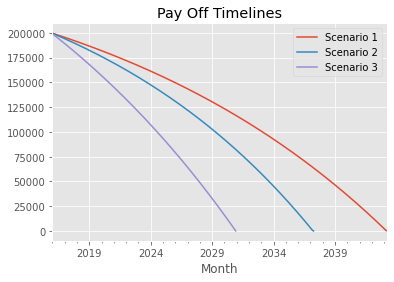

In [20]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Month', y='End Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Month', y='End Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Month', y='End Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");

In [21]:
def make_plot_data(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label"""
    y = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    y["Year"] = y["Month"].dt.year
    y.set_index('Year', inplace=True)
    y.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of ${}".format(stats['Years'], stats['Interest Rate']*100, stats['Additional Payment'])
    return y, label
    
y1, label1 = make_plot_data(schedule1, stats1)
y2, label2 = make_plot_data(schedule2, stats2)
y3, label3 = make_plot_data(schedule3, stats3)

y = pd.concat([y1, y2, y3], axis=1)

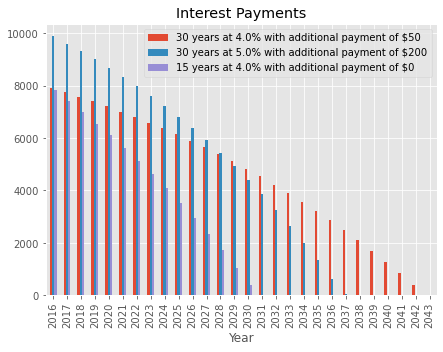

In [22]:
figsize(7,5)
fig, ax = plt.subplots(1, 1)
y.plot(kind="bar", ax=ax)

plt.legend([label1, label2, label3], loc=1, prop={'size':10})
plt.title("Interest Payments");

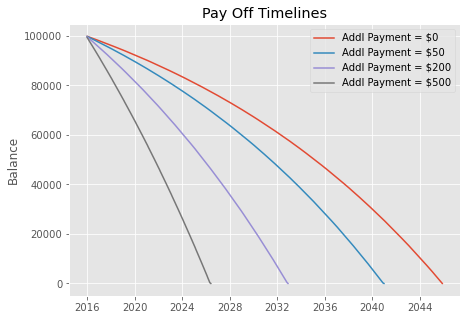

In [66]:
additional_payments = [0, 50, 200, 500]
fig, ax = plt.subplots(1, 1)

for pmt in additional_payments:
    result, _ = amortization_table(100000, .04, 30, addl_principal=pmt, start_date=date(2016,1,1))
    ax.plot(result['Month'], result['End Balance'], label='Addl Payment = ${}'.format(str(pmt)))
plt.title("Pay Off Timelines")
plt.ylabel("Balance")
ax.legend();

###### Internal Rate of Return (IRR)

In [67]:
npf.irr([-250000, 100000, 150000, 200000, 250000, 300000])

0.5672303344358536